# **Deep Learning Prediction of Blood Glucose Sharp Peaks:** Model Test
## **Test**: Determine the Optimal Model Layers

In [1]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.6 MB 36.3 MB/s 


In [2]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
import time
from scipy.signal import savgol_filter, find_peaks
import time
import random as r
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display
import matplotlib
from google.colab import drive

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [3]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Text(0, 0.5, 'Blood Glucoose (mmol/L)')

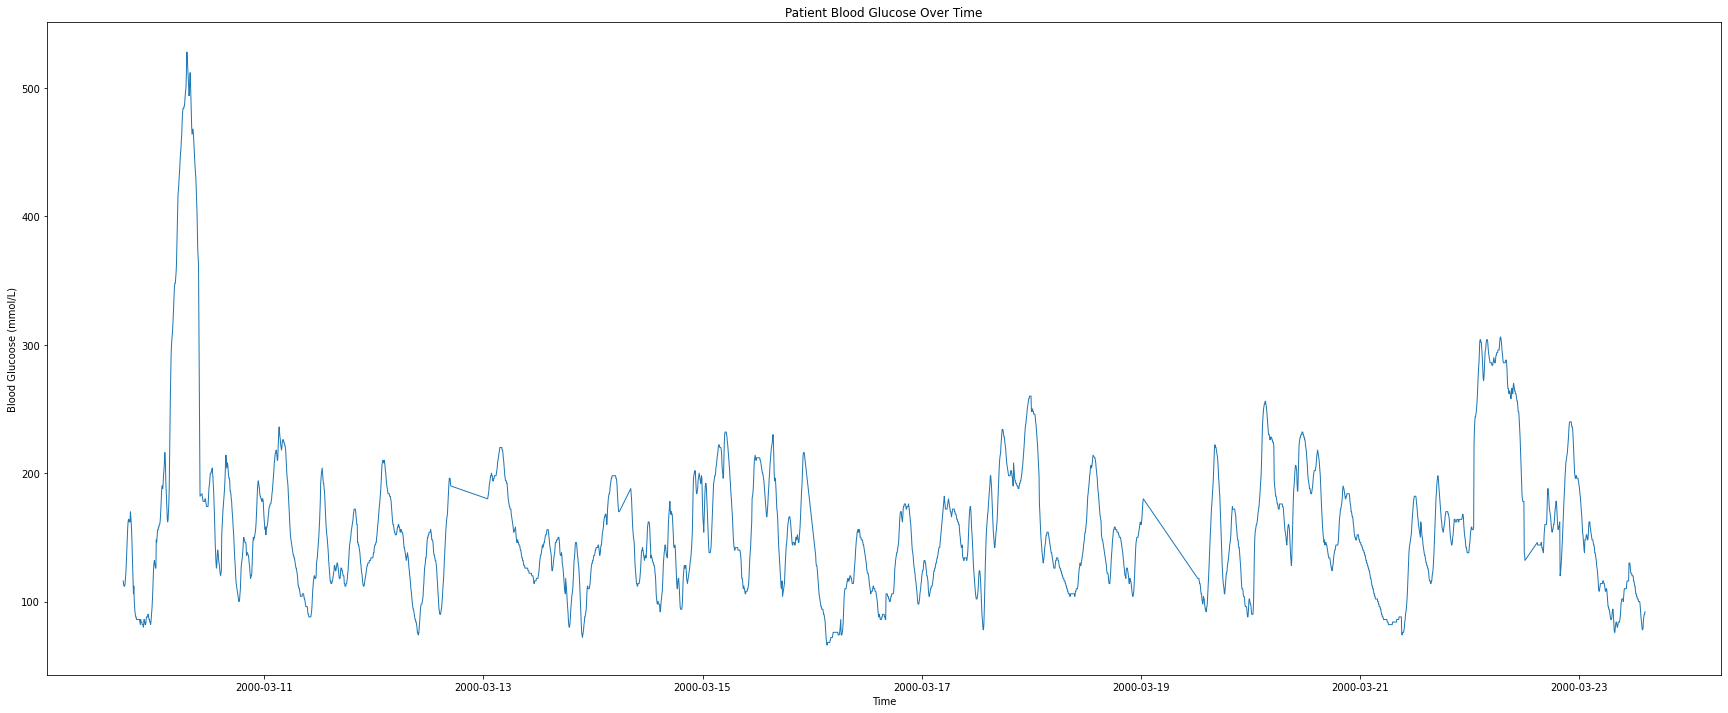

In [4]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

In [5]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts.keys():

  # Format DataFrame
  this_df = pts[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

In [20]:
# Create models dictionary for saving tested models
models = dict()
models_base = dict()
predictions = dict()
timer = dict()

In [7]:
# Split train and test
def splitXandY(df, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Return split
  return [df_train, df_test]

In [8]:
# Prepare the data
df_train, df_test = splitXandY(df)
minMax = MinMaxScaler(feature_range=(-1, 1))
df_train = df_train.drop(columns=['time', 'pt'])
df_test = df_test.drop(columns=['time', 'pt'])

### **Part 2:** Try Different Model Compositions

In [9]:
# Get training set
window = 20
lag = 6
X = []
y = []
y_unf = df_train['glucose_lvl'].to_list()
for i in range(window, len(df_train)-lag):
  X.append(df_train.iloc[(i-window):i])
  y.append([y_unf[i+lag]])
X = np.array(X)
y = np.array(y)
X_test = []

In [10]:
# Do the same for test frame
X_test = []
y_test = []
y_unf = df_test['glucose_lvl'].to_list()
for i in range(window, len(df_test)-lag):
  X_test.append(df_test.iloc[(i-window):i])
  y_test.append([y_unf[i]+lag])
X_test = np.array(X)
y_test = np.array(y)

In [21]:
# GRU models

# One GRU layer model
gru_1 = keras.models.Sequential()
gru_1.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
gru_1.add(keras.layers.GRU(50, return_sequences=True))
gru_1.add(keras.layers.Dense(25, activation='relu'))
gru_1.add(keras.layers.Dropout(0.2))
gru_1.add(keras.layers.Flatten())
gru_1.add(keras.layers.Dense(1, activation='linear'))
models_base['GRU 1'] = gru_1

# Two GRU layer model
gru_2 = keras.models.Sequential()
gru_2.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
gru_2.add(keras.layers.GRU(50, return_sequences=True))
gru_2.add(keras.layers.Dense(25, activation='relu'))
gru_2.add(keras.layers.Dropout(0.2))
gru_2.add(keras.layers.GRU(25, return_sequences=True))
gru_2.add(keras.layers.Dense(10, activation='relu'))
gru_2.add(keras.layers.Dropout(0.2))
gru_2.add(keras.layers.Flatten())
gru_2.add(keras.layers.Dense(1, activation='linear'))
models_base['GRU 2'] = gru_2

# Three GRU layer model
gru_3 = keras.models.Sequential()
gru_3.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
gru_3.add(keras.layers.GRU(50, return_sequences=True))
gru_3.add(keras.layers.Dense(25, activation='relu'))
gru_3.add(keras.layers.Dropout(0.2))
gru_3.add(keras.layers.GRU(25, return_sequences=True))
gru_3.add(keras.layers.Dense(10, activation='relu'))
gru_3.add(keras.layers.Dropout(0.2))
gru_3.add(keras.layers.GRU(10, return_sequences=True))
gru_3.add(keras.layers.Dense(5, activation='relu'))
gru_3.add(keras.layers.Dropout(0.2))
gru_3.add(keras.layers.Flatten())
gru_3.add(keras.layers.Dense(1, activation='linear'))
models_base['GRU 3'] = gru_3

# Four GRU layer model
gru_4 = keras.models.Sequential()
gru_4.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
gru_4.add(keras.layers.GRU(50, return_sequences=True))
gru_4.add(keras.layers.Dense(25, activation='relu'))
gru_4.add(keras.layers.Dropout(0.2))
gru_4.add(keras.layers.GRU(25, return_sequences=True))
gru_4.add(keras.layers.Dense(10, activation='relu'))
gru_4.add(keras.layers.Dropout(0.2))
gru_4.add(keras.layers.GRU(10, return_sequences=True))
gru_4.add(keras.layers.Dense(5, activation='relu'))
gru_4.add(keras.layers.Dropout(0.2))
gru_4.add(keras.layers.GRU(5, return_sequences=True))
gru_4.add(keras.layers.Dense(5, activation='relu'))
gru_4.add(keras.layers.Dropout(0.2))
gru_4.add(keras.layers.Flatten())
gru_4.add(keras.layers.Dense(1, activation='linear'))
models_base['GRU 4'] = gru_4

In [22]:
# LSTM models

# One GRU layer model
lstm_1 = keras.models.Sequential()
lstm_1.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
lstm_1.add(keras.layers.LSTM(50, return_sequences=True))
lstm_1.add(keras.layers.Dense(25, activation='relu'))
lstm_1.add(keras.layers.Dropout(0.2))
lstm_1.add(keras.layers.Flatten())
lstm_1.add(keras.layers.Dense(1, activation='linear'))
models_base['LSTM 1'] = lstm_1

# Two GRU layer model
lstm_2 = keras.models.Sequential()
lstm_2.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
lstm_2.add(keras.layers.LSTM(50, return_sequences=True))
lstm_2.add(keras.layers.Dense(25, activation='relu'))
lstm_2.add(keras.layers.Dropout(0.2))
lstm_2.add(keras.layers.LSTM(25, return_sequences=True))
lstm_2.add(keras.layers.Dense(10, activation='relu'))
lstm_2.add(keras.layers.Dropout(0.2))
lstm_2.add(keras.layers.Flatten())
lstm_2.add(keras.layers.Dense(1, activation='linear'))
models_base['LSTM 2'] = lstm_2

# Three GRU layer model
lstm_3 = keras.models.Sequential()
lstm_3.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
lstm_3.add(keras.layers.LSTM(50, return_sequences=True))
lstm_3.add(keras.layers.Dense(25, activation='relu'))
lstm_3.add(keras.layers.Dropout(0.2))
lstm_3.add(keras.layers.LSTM(25, return_sequences=True))
lstm_3.add(keras.layers.Dense(10, activation='relu'))
lstm_3.add(keras.layers.Dropout(0.2))
lstm_3.add(keras.layers.LSTM(10, return_sequences=True))
lstm_3.add(keras.layers.Dense(5, activation='relu'))
lstm_3.add(keras.layers.Dropout(0.2))
lstm_3.add(keras.layers.Flatten())
lstm_3.add(keras.layers.Dense(1, activation='linear'))
models_base['LSTM 3'] = lstm_3

# Four GRU layer model
lstm_4 = keras.models.Sequential()
lstm_4.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
lstm_4.add(keras.layers.LSTM(50, return_sequences=True))
lstm_4.add(keras.layers.Dense(25, activation='relu'))
lstm_4.add(keras.layers.Dropout(0.2))
lstm_4.add(keras.layers.LSTM(25, return_sequences=True))
lstm_4.add(keras.layers.Dense(10, activation='relu'))
lstm_4.add(keras.layers.Dropout(0.2))
lstm_4.add(keras.layers.LSTM(10, return_sequences=True))
lstm_4.add(keras.layers.Dense(5, activation='relu'))
lstm_4.add(keras.layers.Dropout(0.2))
lstm_4.add(keras.layers.LSTM(5, return_sequences=True))
lstm_4.add(keras.layers.Dense(5, activation='relu'))
lstm_4.add(keras.layers.Dropout(0.2))
lstm_4.add(keras.layers.Flatten())
lstm_4.add(keras.layers.Dense(1, activation='linear'))
models_base['LSTM 4'] = lstm_4

In [23]:
# Mixed models

# Two GRU layer model
mixed_2 = keras.models.Sequential()
mixed_2.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
mixed_2.add(keras.layers.LSTM(50, return_sequences=True))
mixed_2.add(keras.layers.Dense(25, activation='relu'))
mixed_2.add(keras.layers.Dropout(0.2))
mixed_2.add(keras.layers.GRU(25, return_sequences=True))
mixed_2.add(keras.layers.Dense(10, activation='relu'))
mixed_2.add(keras.layers.Dropout(0.2))
mixed_2.add(keras.layers.Flatten())
mixed_2.add(keras.layers.Dense(1, activation='linear'))
models_base['Mixed 2'] = mixed_2

# Three GRU layer model
mixed_3 = keras.models.Sequential()
mixed_3.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
mixed_3.add(keras.layers.LSTM(50, return_sequences=True))
mixed_3.add(keras.layers.Dense(25, activation='relu'))
mixed_3.add(keras.layers.Dropout(0.2))
mixed_3.add(keras.layers.GRU(25, return_sequences=True))
mixed_3.add(keras.layers.Dense(10, activation='relu'))
mixed_3.add(keras.layers.Dropout(0.2))
mixed_3.add(keras.layers.LSTM(10, return_sequences=True))
mixed_3.add(keras.layers.Dense(5, activation='relu'))
mixed_3.add(keras.layers.Dropout(0.2))
mixed_3.add(keras.layers.Flatten())
mixed_3.add(keras.layers.Dense(1, activation='linear'))
models_base['Mixed 3'] = mixed_3

# Four GRU layer model
mixed_4 = keras.models.Sequential()
mixed_4.add(keras.layers.InputLayer(input_shape=[X.shape[1], X.shape[2]]))
mixed_4.add(keras.layers.LSTM(50, return_sequences=True))
mixed_4.add(keras.layers.Dense(25, activation='relu'))
mixed_4.add(keras.layers.Dropout(0.2))
mixed_4.add(keras.layers.GRU(25, return_sequences=True))
mixed_4.add(keras.layers.Dense(10, activation='relu'))
mixed_4.add(keras.layers.Dropout(0.2))
mixed_4.add(keras.layers.LSTM(10, return_sequences=True))
mixed_4.add(keras.layers.Dense(5, activation='relu'))
mixed_4.add(keras.layers.Dropout(0.2))
mixed_4.add(keras.layers.GRU(5, return_sequences=True))
mixed_4.add(keras.layers.Dense(5, activation='relu'))
mixed_4.add(keras.layers.Dropout(0.2))
mixed_4.add(keras.layers.Flatten())
mixed_4.add(keras.layers.Dense(1, activation='linear'))
models_base['Mixed 4'] = mixed_4

In [24]:
# Excute training for each model
for key in models_base.keys():

  # Get this model
  model = models_base[key]
  print(f'Executing: {key}')

  # Start timer
  t_init = time.time()

  # Train model
  model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error'])
  es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1,
                                  patience=10)
  m = model.fit(X, y, epochs=20, batch_size=500, callbacks=[es])

  # Get prediction
  y_pred = m.model.predict(X_test)

  # End timer
  t_end = time.time()

  # Models
  models[f'{key}'] = m
  predictions[f'{key}'] = y_pred
  timer[f'{key}'] = t_end - t_init

Executing: GRU 1
Epoch 1/20
1266/1266 [==============================] - 8s 5ms/step - loss: 3415.4705 - mean_squared_error: 3415.4705
Epoch 2/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1336.6539 - mean_squared_error: 1336.6539
Epoch 3/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1286.9038 - mean_squared_error: 1286.9038
Epoch 4/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1271.2854 - mean_squared_error: 1271.2854
Epoch 5/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1258.9207 - mean_squared_error: 1258.9207
Epoch 6/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1255.4138 - mean_squared_error: 1255.4138
Epoch 7/20
1266/1266 [==============================] - 7s 5ms/step - loss: 1250.2169 - mean_squared_error: 1250.2169
Epoch 8/20
1266/1266 [==============================] - 6s 5ms/step - loss: 1246.6696 - mean_squared_error: 1246.6696
Epoch 9/20
1266/1266 [=================

### **Part 3:** Visualizations

[Text(0, 0, 'GRU'), Text(0, 0, 'LSTM'), Text(0, 0, 'GRU/LSTM Mix')]

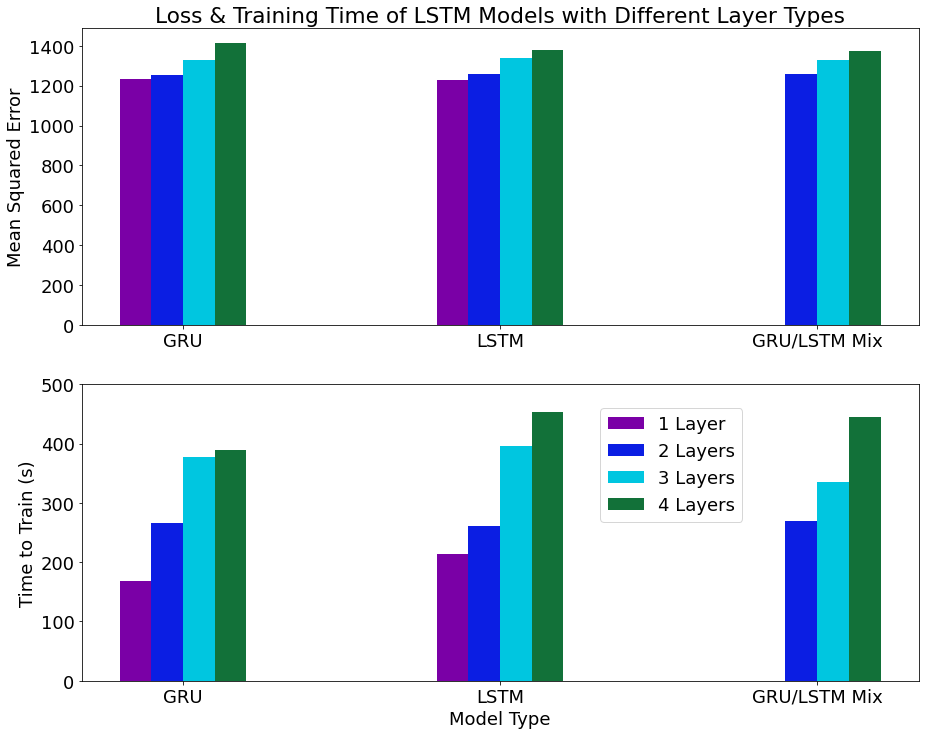

In [26]:
# Plot mean squared errors
fig, axs = plt.subplots(2, figsize=(15, 12))

# Get loss values
loss = list(map(lambda key : models[key].history['loss'][-1], models.keys()))
keys = ['GRU', 'LSTM', 'GRU/LSTM Mix']
loss_grouped = [loss[0:4], loss[4:8], loss[8:]]
loss_grouped[2].insert(0, 0)
times = list(map(lambda key : timer[key], timer.keys()))
times_grouped = [times[0:4], times[4:8], times[8:]]
times_grouped[2].insert(0, 0)

# Plot these values
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)
width = 0.1
ind = np.arange(3)
layers = ['1 Layer', '2 Layers', '3 Layers', '4 Layers']
colors = ['#7A00A6', '#0B1EE3', '#00C6E0', '#127139']
for n in range(4):

  # First plot loss
  this_loss = list(map(lambda i : loss_grouped[i][n], range(len(loss_grouped))))
  axs[0].bar(ind + (n-1.5)* width, this_loss, width, label=layers[n],
             color=colors[n])

  # Second plot time
  this_time = list(map(lambda i : times_grouped[i][n], range(len(times_grouped))))
  axs[1].bar(ind + (n-1.5)* width, this_time, width, label=layers[n],
             color=colors[n])

# Add in plot features
axs[0].set_title('Loss & Training Time of LSTM Models with Different Layer Types')
axs[0].set_ylabel('Mean Squared Error')
axs[0].set_xticks(range(0, 3, 1))
axs[0].set_xticklabels(['GRU', 'LSTM', 'GRU/LSTM Mix'])

# Add in plot features
axs[1].set_xlabel('Model Type')
axs[1].set_ylabel('Time to Train (s)')
axs[1].set_ylim([0, 500])
axs[1].legend(bbox_to_anchor=(0.8, 0.95))
axs[1].set_xticks(range(0, 3, 1))
axs[1].set_xticklabels(['GRU', 'LSTM', 'GRU/LSTM Mix'])

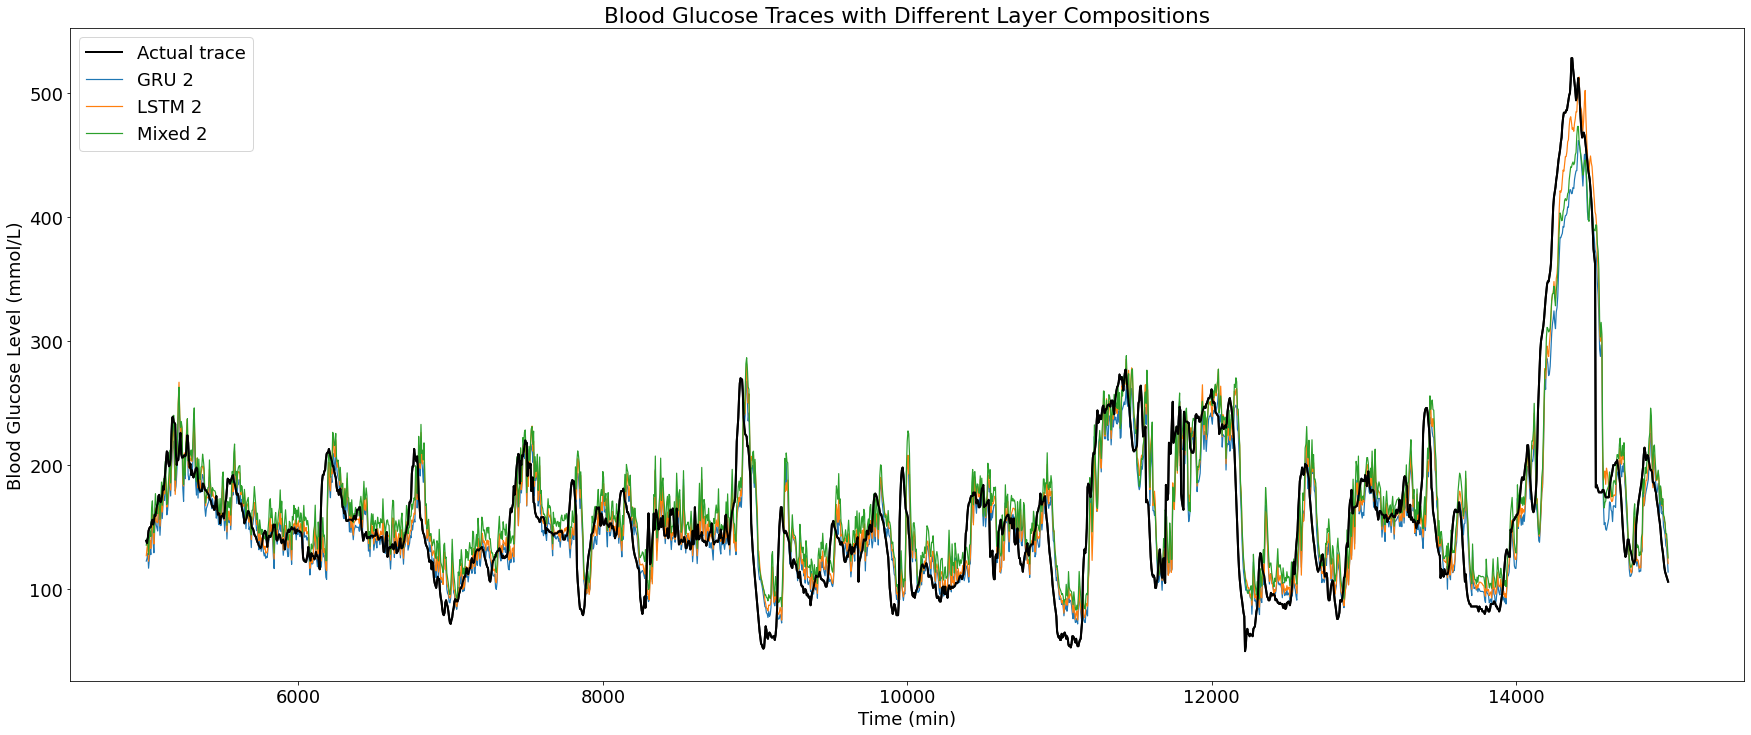

In [28]:
# Plot actual traces as proof of concept
fig, ax = plt.subplots(figsize=(30, 12))

# Plot different predictions on the same graph
time_values = list(range(5000, 15001, 5))
ax.plot(time_values, y_test[950:2951], linewidth=2.0, color='black', label='Actual trace')
models_int = ['GRU 2', 'LSTM 2', 'Mixed 2']
for model in models_int:
  prediction = predictions[model]
  ax.plot(time_values, prediction[(1000-52):(3001-52)], label=model,
          linewidth=1.2)
ax.plot(time_values, y_test[950:2951], linewidth=2.0, color='black')

# Add labels
ax.set_ylabel('Blood Glucose Level (mmol/L)')
ax.set_xlabel('Time (min)')
ax.set_title('Blood Glucose Traces with Different Layer Compositions')
ax.legend()

### **Part 4:** Save Outputs

In [29]:
# Prepare models
i = 1
for key in models.keys():
  model = models[key]
  model.model.save(f'layers_test_{i}')
  i += 1

In [30]:
# Copy to drive
drive.mount('/content/drive')
!cp -r layers_test_1/ "/content/drive/My Drive/"
!cp -r layers_test_2/ "/content/drive/My Drive/"
!cp -r layers_test_3/ "/content/drive/My Drive/"
!cp -r layers_test_4/ "/content/drive/My Drive/"
!cp -r layers_test_5/ "/content/drive/My Drive/"
!cp -r layers_test_6/ "/content/drive/My Drive/"
!cp -r layers_test_7/ "/content/drive/My Drive/"
!cp -r layers_test_8/ "/content/drive/My Drive/"
!cp -r layers_test_9/ "/content/drive/My Drive/"
!cp -r layers_test_10/ "/content/drive/My Drive/"
!cp -r layers_test_11/ "/content/drive/My Drive/"

Mounted at /content/drive
